In [1]:
#Libraries
library(ggplot2)
library(knitr)

In [2]:
# Parameters
R = 1000 # radius of the spherical shell in arbitrary units
delta_R = 10 # thickness of the shell in arbitrary units
n = 1e-6 # density of sources per cubic unit
h0 = 1 # reference strain amplitude at distance 1
w = 0.1 # width of the Gaussian
n_observed = 10
num_simulations = 10000
set.seed(123)

# Function to calculate volume of the spherical shell
volume_shell = function(R, delta_R) {
  V_outer = (4/3) * pi * (R + delta_R)^3
  V_inner = (4/3) * pi * R^3
  return(V_outer - V_inner)
}

V_shell = volume_shell(R, delta_R)

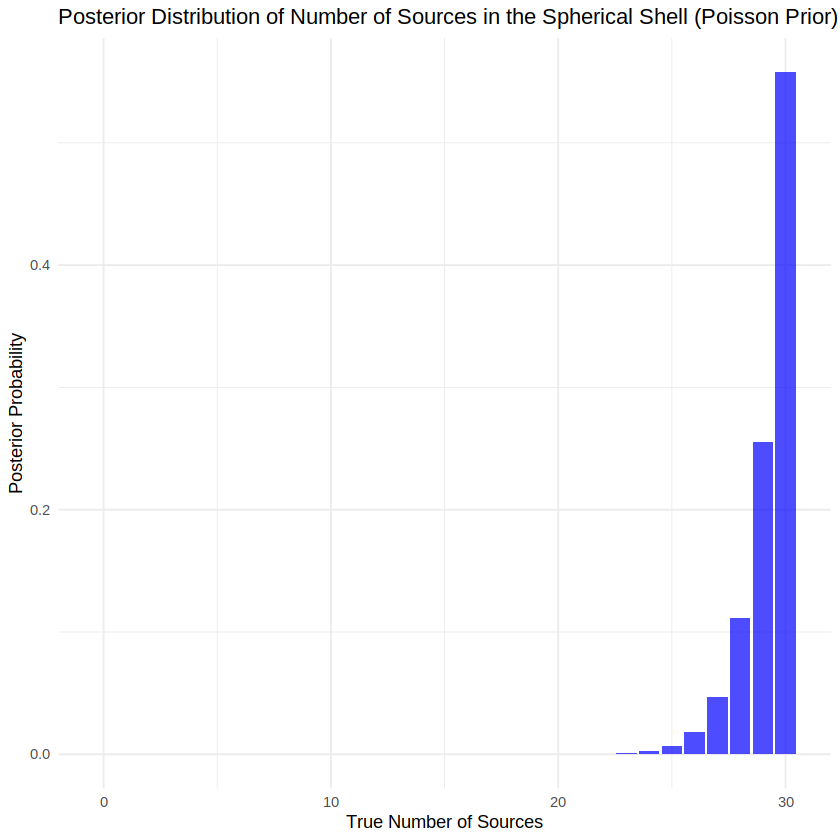

In [3]:
# Poisson prior and likelihood

lambda = n * V_shell # expected number of sources in the shell

prior_poisson = function(n_true, lambda) {
  dpois(n_true, lambda)
}

likelihood = function(n_observed, n_true) {
  dpois(n_observed, n_true)
}

posterior_poisson = function(n_observed, lambda) {
  n_true_values = 0:(n_observed + 20)
  posterior_values = sapply(n_true_values, function(n_true) {
    likelihood(n_observed, n_true) * prior_poisson(n_true, lambda)
  })
  posterior_values = posterior_values / sum(posterior_values)
  data.frame(n_true = n_true_values, posterior = posterior_values)
}

posterior_distribution_poisson = posterior_poisson(n_observed, lambda)
posterior_mean_poisson = sum(posterior_distribution_poisson$n_true * posterior_distribution_poisson$posterior)
posterior_variance_poisson = sum((posterior_distribution_poisson$n_true^2) * posterior_distribution_poisson$posterior) - posterior_mean_poisson^2

ggplot(posterior_distribution_poisson, aes(x = n_true, y = posterior)) +
  geom_bar(stat = "identity", fill = "blue", alpha = 0.7) +
  labs(title = "Posterior Distribution of Number of Sources in the Spherical Shell (Poisson Prior)",
       x = "True Number of Sources",
       y = "Posterior Probability") +
  theme_minimal()

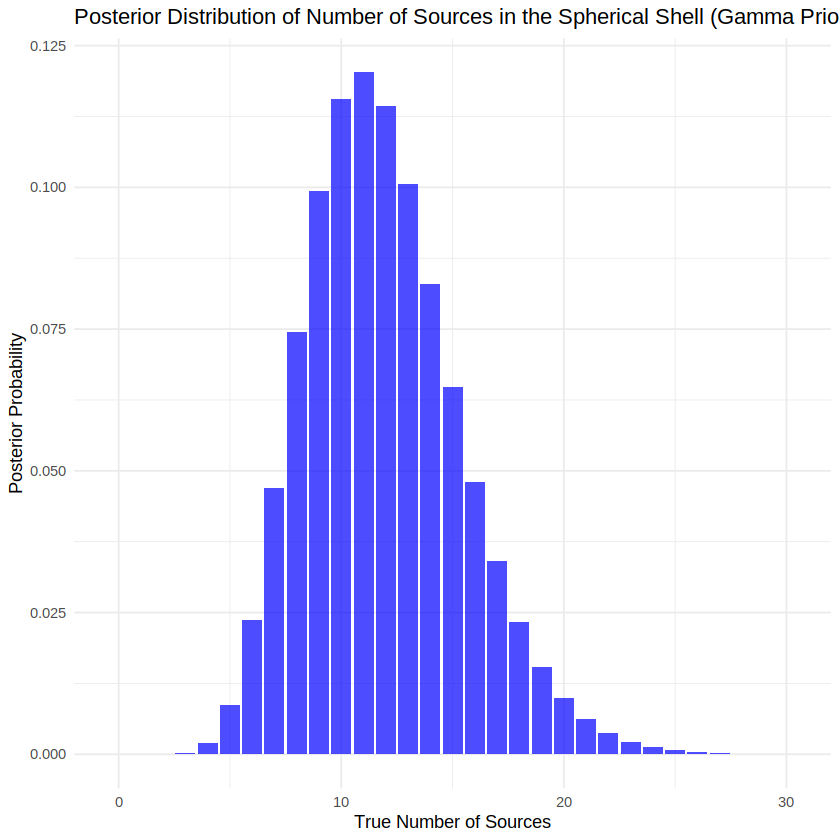

In [4]:
# Gamma prior
alpha = 2 # shape parameter
beta = 1 / lambda # rate parameter

prior_gamma = function(n_true, alpha, beta) {
  dgamma(n_true, shape = alpha, rate = beta)
}

posterior_gamma = function(n_observed, alpha, beta) {
  n_true_values = 0:(n_observed + 20)
  posterior_values = sapply(n_true_values, function(n_true) {
    likelihood(n_observed, n_true) * prior_gamma(n_true, alpha, beta)
  })
  posterior_values = posterior_values / sum(posterior_values)
  data.frame(n_true = n_true_values, posterior = posterior_values)
}

posterior_distribution_gamma = posterior_gamma(n_observed, alpha, beta)
posterior_mean_gamma = sum(posterior_distribution_gamma$n_true * posterior_distribution_gamma$posterior)
posterior_variance_gamma = sum((posterior_distribution_gamma$n_true^2) * posterior_distribution_gamma$posterior) - posterior_mean_gamma^2

ggplot(posterior_distribution_gamma, aes(x = n_true, y = posterior)) +
  geom_bar(stat = "identity", fill = "blue", alpha = 0.7) +
  labs(title = "Posterior Distribution of Number of Sources in the Spherical Shell (Gamma Prior)",
       x = "True Number of Sources",
       y = "Posterior Probability") +
  theme_minimal()

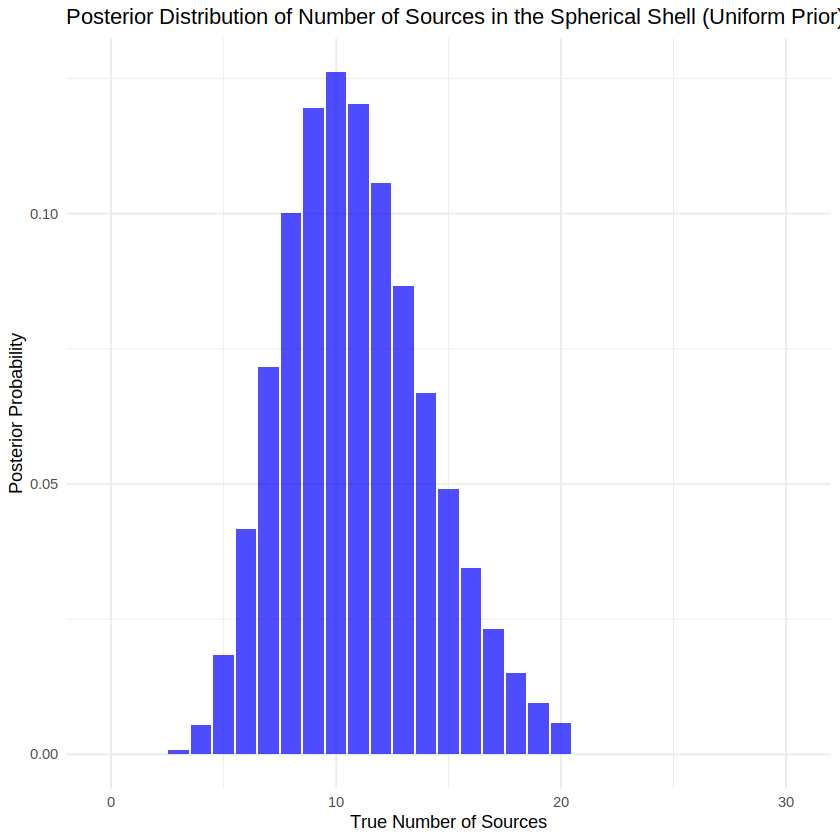

In [5]:
# Uniform prior
prior_uniform = function(n_true, min_val, max_val) {
  ifelse(n_true >= min_val & n_true <= max_val, 1 / (max_val - min_val), 0)
}

min_val = 0
max_val = 20

posterior_uniform = function(n_observed, min_val, max_val) {
  n_true_values = 0:(n_observed + 20)
  posterior_values = sapply(n_true_values, function(n_true) {
    likelihood(n_observed, n_true) * prior_uniform(n_true, min_val, max_val)
  })
  posterior_values = posterior_values / sum(posterior_values)
  data.frame(n_true = n_true_values, posterior = posterior_values)
}

posterior_distribution_uniform = posterior_uniform(n_observed, min_val, max_val)
posterior_mean_uniform = sum(posterior_distribution_uniform$n_true * posterior_distribution_uniform$posterior)
posterior_variance_uniform = sum((posterior_distribution_uniform$n_true^2) * posterior_distribution_uniform$posterior) - posterior_mean_uniform^2

ggplot(posterior_distribution_uniform, aes(x = n_true, y = posterior)) +
  geom_bar(stat = "identity", fill = "blue", alpha = 0.7) +
  labs(title = "Posterior Distribution of Number of Sources in the Spherical Shell (Uniform Prior)",
       x = "True Number of Sources",
       y = "Posterior Probability") +
  theme_minimal()

In [6]:
# Create a table to compare the results
results <- data.frame(
  Prior = c("Poisson", "Gamma", "Uniform"),
  Mean = c(posterior_mean_poisson, posterior_mean_gamma, posterior_mean_uniform),
  Variance = c(posterior_variance_poisson, posterior_variance_gamma, posterior_variance_uniform)
)

# Display the table using knitr
kable(results, caption = "Comparison of Posterior Means and Variances for Different Priors")



Table: Comparison of Posterior Means and Variances for Different Priors

|Prior   |     Mean|  Variance|
|:-------|--------:|---------:|
|Poisson | 29.24980|  1.181784|
|Gamma   | 11.90542| 11.797843|
|Uniform | 10.90740| 10.015519|



Table: Posterior Mean and Variance for Gamma Prior with Detection Efficiency

|Prior | Mean| Variance|
|:-----|----:|--------:|
|Gamma |   24|        0|

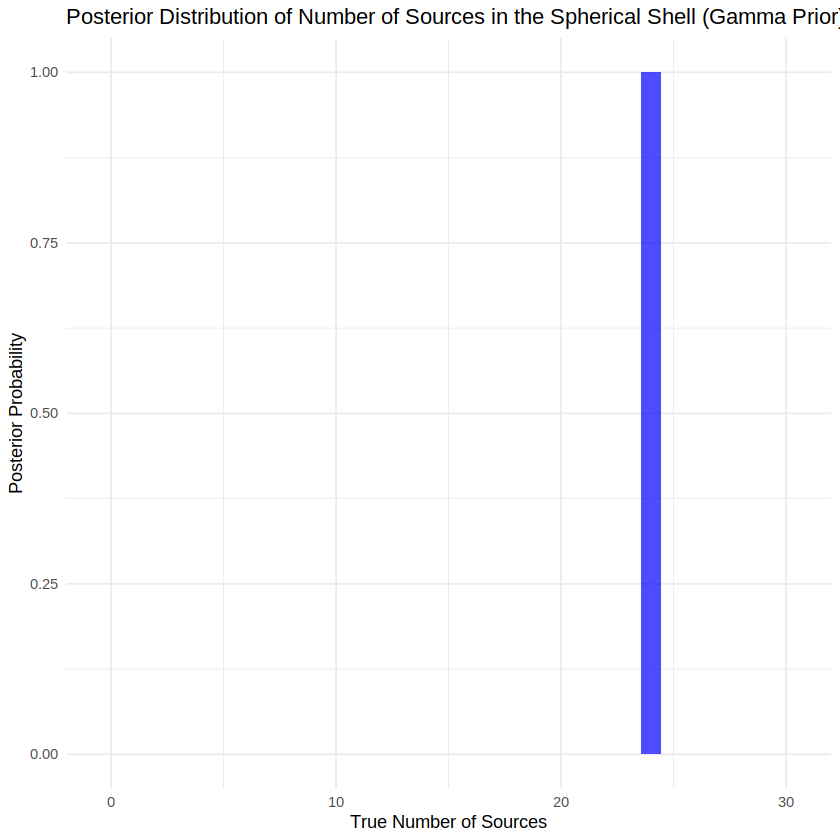

In [15]:
# Libraries
library(ggplot2)
library(knitr)

# Parameters
R = 1000 # radius of the spherical shell in arbitrary units
delta_R = 10 # thickness of the shell in arbitrary units
n = 1e-6 # density of sources per cubic unit
h0 = 1 # reference strain amplitude at distance 1
w = 0.1 # width of the Gaussian
n_observed = 10
set.seed(123)

# Function to calculate volume of the spherical shell
volume_shell = function(R, delta_R) {
  V_outer = (4/3) * pi * (R + delta_R)^3
  V_inner = (4/3) * pi * R^3
  return(V_outer - V_inner)
}

V_shell = volume_shell(R, delta_R)

# Detection efficiency function
detection_efficiency = function(R, h0) {
  return(h0 / R) # constant detection efficiency
}

# Poisson prior and likelihood

lambda = n * V_shell # expected number of sources in the shell

# Gamma prior
alpha = 2 # shape parameter
beta = 1 / lambda # rate parameter

prior_gamma = function(n_true, alpha, beta) {
  dgamma(n_true, shape = alpha, rate = beta)
}

# Update likelihood to include detection efficiency
likelihood = function(n_observed, n_true, R, h0) {
  detection_prob = detection_efficiency(R, h0)
  detected_sources = rbinom(1, n_true, detection_prob)
  dpois(n_observed, detected_sources)
}

posterior_gamma = function(n_observed, alpha, beta, R, h0) {
  n_true_values = 0:(n_observed + 20)
  posterior_values = sapply(n_true_values, function(n_true) {
    likelihood(n_observed, n_true, R, h0) * prior_gamma(n_true, alpha, beta)
  })
  posterior_values = posterior_values / sum(posterior_values, na.rm = TRUE)
  data.frame(n_true = n_true_values, posterior = posterior_values)
}

posterior_distribution_gamma = posterior_gamma(n_observed, alpha, beta, R, h0)
posterior_mean_gamma = sum(posterior_distribution_gamma$n_true * posterior_distribution_gamma$posterior, na.rm = TRUE)
posterior_variance_gamma = sum((posterior_distribution_gamma$n_true^2) * posterior_distribution_gamma$posterior, na.rm = TRUE) - posterior_mean_gamma^2

# Plot the posterior distribution
ggplot(posterior_distribution_gamma, aes(x = n_true, y = posterior)) +
  geom_bar(stat = "identity", fill = "blue", alpha = 0.7) +
  labs(title = "Posterior Distribution of Number of Sources in the Spherical Shell (Gamma Prior)",
       x = "True Number of Sources",
       y = "Posterior Probability") +
  theme_minimal()

# Display the results using knitr
results <- data.frame(
  Prior = "Gamma",
  Mean = posterior_mean_gamma,
  Variance = posterior_variance_gamma
)

kable(results, caption = "Posterior Mean and Variance for Gamma Prior with Detection Efficiency")
